In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from pandas import DataFrame, concat
from pprint import pprint
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(parent_dir)

assert os.path.exists('data') == True, (
    'diretório data não encontrado. '
    'Certifique-se de que o diretório data existe no diretório raiz desse '
    'projeto, com os arquivos necessários dentro.'
)

os.makedirs('results', exist_ok=True)



# Constantes

Os valores abaixo serão utilizados para retornar os valores de previsão para a escala original. 

Além de desnormalizar é necessário readicionar a tendência que foi retirada a partir da diferenciação da série do ICMS-RJ.

In [2]:
# Constantes para a validação
# 25 valores para criar 13 intervalos de 12 meses
icms_initial_values = [3054647241.0, 2899400405.0, 2718750710.0, 
                       2784291530.0, 2988242758.0, 2728014302.0, 
                       3400196101.0, 3228952138.0, 2873691468.0, 
                       2694165362.0, 4479663014.0, 2867019408.0, 
                       3586300282.0, 3192884893.0, 2763545556.0, 
                       3193576905.0, 2983787440.0, 2737799049.08, 
                       2753485166.27, 2931044987.21, 3114528093.4, 
                       3124850205.99, 3143348373.33, 3490147653.84,
                       3859316053.66]

cb_initial_values = [443.81, 438.36, 441.19, 440.06, 446.03, 445.58, 
                     421.89, 417.05, 418.48, 443.69, 460.24, 466.75, 
                     460.46, 464.47, 496.33, 515.58, 492.93, 498.67, 
                     479.28, 462.24, 458.21, 462.57, 455.37, 516.91,
                     644.0]

petr_initial_values = [2724, 2729, 2672, 2714, 2718, 2707, 2690, 2614, 
                       2578, 2717, 2671, 2794, 2730, 2582, 2655, 2700, 
                       2834, 2654, 2877, 3097, 3038, 3075, 3203, 3216,
                       2969]

trib_initial_values = [4869304104.0, 3911455913.0, 3553175853.0, 
                       3557404009.0, 3632787716.0, 3305049163.0, 
                       4047070676.0, 3901651824.0, 3444939721.0, 
                       3272112477.0, 5096900924.0, 3456062224.0, 
                       5464521206.0, 4185558828.0, 3621893885.0, 
                       3959255086.0, 3592748799.0, 3300752325.67, 
                       3321406806.42, 3508106369.08, 3641413728.43, 
                       3665239552.24, 3657823494.71, 4063564350.02,
                       5496860058.37]

ener_initial_values = [20078.0, 19690.0, 20853.0, 20733.0, 19736.0, 19179.0, 
                       19273.0, 19378.0, 19600.0, 20110.0, 20154.0, 20022.0, 
                       20966.0, 20585.0, 20626.0, 19828.0, 20187.0, 18981.0, 
                       18700.0, 18900.0, 19292.0, 20171.0, 20623.0, 19593.0,
                       21498.0]

# Constantes para os testes
icms_test_real = [4327920118.33, 3621238631.11, 3349671547.87, 
                  4123153077.77, 3750000648.34, 4142199873.63, 
                  3574957480.03, 3409293931.52, 4297149120.6, 
                  3404457118.32, 3622801505.3, 3334894194.52]

initial_icms_test_value = 4021877984.35


#### Importando e Plotando as séries
No CSV estão salvas apenas as séries selecionadas após a aplicação do DTW e diferenciadas para remover a tendência. Por esse motivo todas as séries são estacionárias.

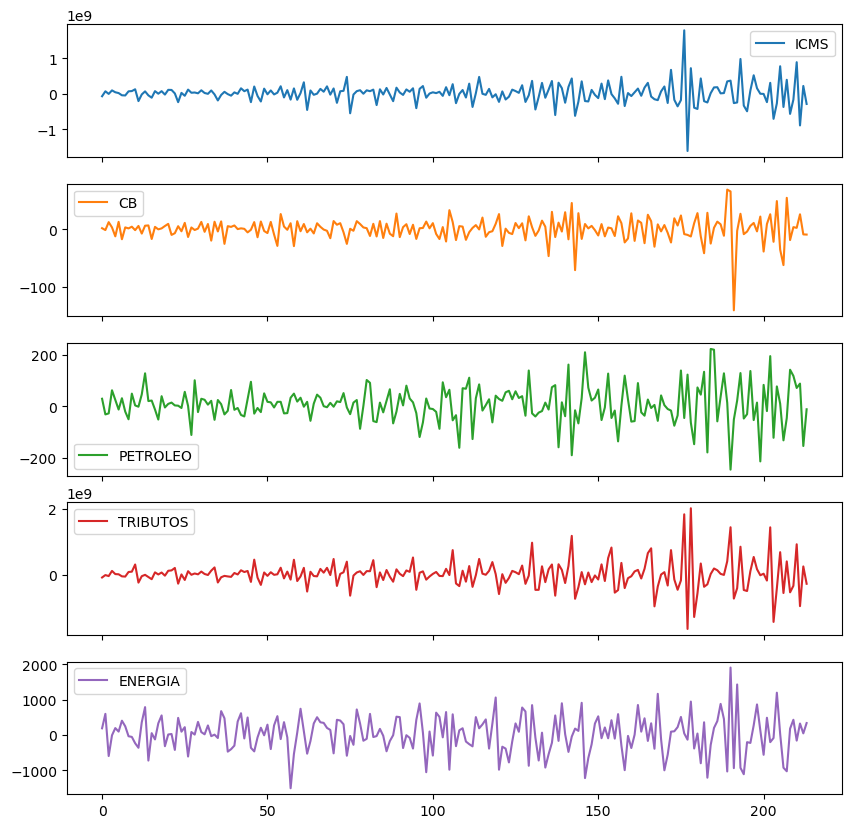

In [3]:
df = pd.read_csv('data/selected.csv', header=0, names=['ANO', 'MES', 'ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA'])
plot = df[df.columns[2:]].plot(figsize=(10, 10), subplots=True)

## Separando o conjunto de Teste

In [4]:
df_test = df[df['ANO'] == 2022].copy()
df = df[df['ANO'] != 2022].copy()
print(df.shape, df_test.shape)

(202, 7) (12, 7)


## Normalizando as séries
Os valores Máximo e Mínimo do ICMS são salvos para que seja possível retornar com as previsões para as escala original.

In [5]:
#Normalizing data   
_min = df['ICMS'].min()
_max = df['ICMS'].max()

cb_min = df['CB'].min()
cb_max = df['CB'].max()

petr_min = df['PETROLEO'].min()
petr_max = df['PETROLEO'].max()

trib_min = df['TRIBUTOS'].min()
trib_max = df['TRIBUTOS'].max()

ener_min = df['ENERGIA'].min()
ener_max = df['ENERGIA'].max()

for col in df.columns[2:]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [6]:
df.head()

,ANO,MES,ICMS,CB,PETROLEO,TRIBUTOS,ENERGIA
0,2004.0,3.0,0.453713,0.680444,0.587234,0.426264,0.496627
1,2004.0,4.0,0.494609,0.664873,0.457447,0.446347,0.616310
2,2004.0,5.0,0.473085,0.730537,0.465957,0.437884,0.266940
3,2004.0,6.0,0.502279,0.686920,0.657447,0.480698,0.438838
4,2004.0,7.0,0.486677,0.612923,0.578723,0.454444,0.498387


# Definição de funções

In [229]:
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{columns[j]}(t-{i})') for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{columns[j]}(t+{i})') for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def calculate_error(y_pred, y_val):
    """
    Function to calculate the errors RMSE, MAE and MAPE
    Parameters:
    y_pred: numpy array with the predicted values (without normalization and retrended)
    y_val: numpy array with the real values (without normalization and retrended)
    return:
    rmse: RMSE value
    mae: MAE value
    mape: MAPE value
    """
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    mae = np.mean(np.abs(y_val - y_pred))
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    return rmse, mae, mape


def get_val_metrics(model, X_val, y_val, plot_many=False, plot_one=True):
    
    rmse_list  = []
    mae_list = []
    mape_list  = []
    n_target = y_val.shape[1]

    if plot_many:
        fig, axs = plt.subplots(13, figsize=(4, 20))
    if plot_one:
        chosen = np.random.randint(0, 25)
        fig, axs = plt.subplots(1, figsize=(4, 2))

    for i in range(25):

        initial = icms_initial_values[i]
        y_pred = []


        # Multi-step prediction
        for j in range(12):
            yhat = model.predict(X_case, verbose=0)
            y_pred.append(yhat[0][0])
            #print(f'Predicted: {yhat}')
            X_case = np.concatenate([X_case[:, n_target:, :], 
                                     yhat.reshape(1, n_target, -1)], axis=1)
        
        # Desnormalizing
        y_pred = np.array(y_pred).reshape(-1, 1)
        y_pred = y_pred * (_max - _min) + _min
        y_val_case = y_val[i:i+12]
        if(n_target == 2):
            y_val_case = y_val_case.reshape(12, 2)
            y_val_case, _ = np.split(y_val_case, 2, axis=1)
        if(n_target == 5):
            y_val_case = y_val_case.reshape(12, 5)
            y_val_case, _, _, _, _ = np.split(y_val_case, 5, axis=1)
        y_val_case = y_val_case.reshape(-1, 1) * (_max - _min) + _min

        # Retrending
        for j in range(12):
            if j == 0:
                y_pred[j] = y_pred[j] + initial
                y_val_case[j] = y_val_case[j] + initial
            else:
                y_pred[j] = y_pred[j] + y_pred[j-1]
                y_val_case[j] = y_val_case[j] + y_val_case[j-1]

        #Plotando
        if plot_many:
            if i % 2 == 0:
                axs[i//2].plot(y_val_case, label='Valor real')
                axs[i//2].plot(y_pred, label='Valor predito')
                axs[i//2].legend()
                axs[i//2].set(xticks=np.arange(0, 12, 1), 
                              xticklabels=np.arange(i+1, i+13, 1))
                axs[i//2].set_title(f"{i}º até {i+12}° mês")
        elif plot_one:
            if i == chosen:
                axs.plot(y_val_case, label='Valor real')
                axs.plot(y_pred, label='Valor predito')
                axs.legend()
                axs.set(xticks=np.arange(0, 12, 1), 
                        xticklabels=np.arange(i+1, i+13, 1))
                axs.set_title(f"{i}º até {i+12}° mês")

        #print(y_pred.shape, y_val_case.shape)
        # Calculating the error
        try: 
            rmse, mae, mape = calculate_error(y_pred, y_val_case)
        except:
            print(f'Error in {i}th case')
            print(f'y_pred: {y_pred.shape},\n y_val_case: {y_val_case.shape}')
            print(f'y_pred: {y_pred},\n y_val_case: {y_val_case}')
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
    
    rmse = np.array(rmse_list).mean()
    mae = np.array(mae_list).mean()
    mape = np.array(mape_list).mean()

    if plot_many or plot_one:
        plt.tight_layout()
        plt.show()

    return rmse, mae, mape

def get_best_model(epochs, batch_size, X_train, y_train, X_val, y_val):
    neurons = [50, 100, 150, 200]
    fn_activation = ['relu', 'tanh', 'sigmoid']

    # neurons = [50, 100, 150, 200, 300]
    # fn_activation = ['relu']

    best_model = None
    best_mape = float('inf')
    best_config = None

    low_patience_es = EarlyStopping(monitor='loss', patience=25)
    for n_neurons in neurons:
        for activation in fn_activation:

            model = bi_lstm(n_neurons=n_neurons, n_features=24, n_target=2, activation=activation)
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[low_patience_es])
            
            rmse, mae, mape = get_val_metrics(model, X_val, y_val, False, False)

            if mape < best_mape:
                best_mape = mape
                best_model = model
                best_config = {'n_neurons': n_neurons, 'activation': activation}

    print('Best MAPE: %.3f' % best_mape)
    return (best_model, best_config, rmse, mae, mape)

def get_best_parameters(best_dict):
    """
    Function to get the best parameters from the dictionary
    Parameters:
    best_dict: Dictionary returned by the grid search
    return: Tuple with the best parameters
        ne: n_estimators
        mss: min_samples_split
        msl: min_samples_leaf
        mf: max_features
        md: max_depth
        b: bootstrap
    """
    ep = best_dict['epochs']
    bs = best_dict['batch_size']
    return ep, bs

def print_mean_error(name, rmse, mae, mape):
    """
    Function to print the mean error
    Parameters:
    name: Name of the case
    rmse: numpy array with the rmse values
    mae: numpy array with the mae values
    mape: numpy array with the mape values
    return: None
    """
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)
    mean_mape = np.mean(mape)
    print(f'{name}')
    print(f'\tRMSE: {mean_rmse:.2f}')
    print(f'\tMAE: {mean_mae:.2f}')
    print(f'\tMAPE: {mean_mape:.2f}')
    print('-'*40)

def get_prediction(test_values, model, initial):
    """
    Function used in test set to predict the next 12 months in a multistep
    forecast. The prediction is made using the model passed as parameter.
    Parameters:
    test_values: numpy array with the values of the last line of the validation set
    model: model used to predict the next 12 months
    initial: initial value of the serie for retrend
    return:
    pred: numpy array with the predicted values denormalized and retrended
    """
    pred = []

    for i in range(12):
        y_hat = model.predict(test_values.reshape(1, 24, 1), verbose=0)
        test_values = np.concatenate([test_values[2:], y_hat.reshape(-1)], axis=0)
        #Desnormalizing
        y_hat = y_hat * (_max - _min) + _min
        pred.append(y_hat[0][0])

    #Retrending
    for i in range(12):
        if i == 0:
            pred[i] = pred[i] + initial
        else:
            pred[i] = pred[i] + pred[i-1]

    pred = np.array(pred)
    return pred

def print_results(name, pred, real):
    """
    Print the results of the model on the test set
    Parameters:
    name: name of the case
    pred: numpy array with the predicted values
    real: numpy array with the real values
    return: None
    """
    rmse, mae, mape = calculate_error(pred, real)
    print(f'{name}')
    print(f'\tRMSE: {rmse:.2f}')
    print(f'\tMAE: {mae:.2f}')
    print(f'\tMAPE: {mape:.2f}')
    print('-'*40)
 
def vanilla_lstm(n_neurons, n_features, n_target, activation='relu'):
    """
    Function that creates a vanilla LSTM model
    Parameters:
    n_neurons: number of neurons in the hidden layer
    n_features: number of steps (lag)
    n_target: number of features (predictors)
    activation: activation function
    return: vanilla LSTM model
    """
    model = Sequential()
    model.add(LSTM(units=n_neurons, activation=activation, input_shape=(n_features, n_target)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def bi_lstm(n_neurons, n_features, n_target, activation='relu'):
    """
    Function that creates a bidirectional LSTM model
    Parameters:
    n_neurons: number of neurons in the hidden layer
    n_features: number of steps (lag)
    n_target: number of features (predictors)
    activation: activation function
    return: bidirectional LSTM model
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(units=n_neurons, activation=activation), input_shape=(n_features, 1)))
    model.add(Dense(n_target))
    model.compile(optimizer='adam', loss='mse')
    return model

def print_best(model_name, epochs, n_neurons, activation, mape):
    print(f"Best LSTM Bidirectional model: {model_name}")
    print(f"\tEpochs: {epochs} | Neurons: {n_neurons} | Activation: {activation}")
    print(f"\tMAPE: {mape:.2f}")

# Univariado
Primeiro vamos usar apenas o ICMS para realizar a previsão multi-step.

In [9]:
icms = series_to_supervised(list(df['ICMS']), ['ICMS'], 12, 1)

icms_X, icms_y = icms.values[:, :-1], icms.values[:, -1]

icms_X = icms_X.reshape((icms_X.shape[0], icms_X.shape[1], 1))
icms_y = icms_y.reshape((icms_X.shape[0], 1))


#### GridSearch com CV para a Random Forest

In [11]:
# Number of epochs to train
epochs = [500, 800, 1000]
# Batch size 
batch_size = [4, 8, 16, 32]

# Create the random grid
random_grid = {'epochs': epochs,
               'batch_size': batch_size
               }

In [13]:
n_neurons = 100
n_features = 12
n_target = 1

vanilla = KerasRegressor(build_fn=vanilla_lstm, n_neurons=n_neurons, 
                         n_features=n_features, n_target=n_target, verbose=0)

vanilla_random = RandomizedSearchCV(estimator=vanilla, 
                                    param_distributions=random_grid, cv=3, 
                                    verbose=2, n_jobs=-1, 
                                    scoring='neg_mean_squared_error', n_iter=6)


vanilla_random.fit(icms_X, icms_y)

v_ep = vanilla_random.best_params_['epochs']
v_bs = vanilla_random.best_params_['batch_size']

C:\Users\jpkqv\AppData\Local\Temp\ipykernel_2792\1660722830.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  vanilla = KerasRegressor(build_fn=vanilla_lstm, n_neurons=n_neurons,


Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [14]:
n_neurons = 100
n_features = 12
n_target = 1
# Use the random grid to search for best hyperparameters
# First create the base model to tune
bidirectional = KerasRegressor(build_fn=bi_lstm, n_neurons=n_neurons, 
                               n_features=n_features, n_target=n_target, verbose=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 6 different combinations, and use all available cores
bi_random = RandomizedSearchCV(estimator=bidirectional, 
                               param_distributions=random_grid, cv=3,
                               verbose=2, n_jobs=-1, 
                               scoring='neg_mean_squared_error', n_iter=6)

# Fit the random search model
#bi_random.fit(icms.values[:, :-1], icms.values[:, -1])
bi_random.fit(icms_X, icms_y)

b_ep = bi_random.best_params_['epochs']
b_bs = bi_random.best_params_['batch_size']

C:\Users\jpkqv\AppData\Local\Temp\ipykernel_2792\3691558803.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  bidirectional = KerasRegressor(build_fn=bi_lstm, n_neurons=n_neurons,


Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [15]:
print(f'Vanilla best LSTM - n_neurons: {n_neurons}, n_target: {n_target}') 
print(f'\t{v_ep} epochs, {v_bs} batch size')
print('-'*40)
# print(f'Stacked best LSTM - n_neurons: {n_neurons}, n_target: {n_target}')
# print(f'\t{s_ep} epochs, {s_bs} batch size')
# print('-'*40)
print(f'Bidirectional best LSTM - n_neurons: {n_neurons}, n_target: {n_target}')
print(f'\t{b_ep} epochs, {b_bs} batch size')

Vanilla best LSTM - n_neurons: 100, n_target: 1
	500 epochs, 16 batch size
----------------------------------------
Bidirectional best LSTM - n_neurons: 100, n_target: 1
	500 epochs, 16 batch size


Rodando uma Random Forest univariada com os valores padrões

Para os 36 meses de validação, foi calculado 25 casos de uma previsão Multistep de 12 meses. A métrica de erro foi obtida através da média do erro desses 25 casos.

São mostrados 12 gráficos que correspondem aos intervalos [0, 12], [2, 14], [4, 16] ... [24, 36].

#### Divisão em Treino e Validação

Dos 190 registros existentes após o janelamento, os últimos 36 (2018,2019, 2021) (~20%) foram escolhidos para fazer parte do conjunto de Validação, enquanto os outros fazem parte do conjunto de treino.

In [16]:
#Dividindo em treino e validação
# train = icms.values[:154, :]
# val = icms.values[154:, :]

#Dividindo em X e y
X_train, y_train = icms_X[:154, :], icms_y[:154, :]
X_val, y_val = icms_X[154:, :], icms_y[154:, :]

In [ ]:
# Finding best Bidirectional model with the best parameters
neurons = [100]
fn_activation = ['relu']

# neurons = [50, 100, 150, 200, 300]
# fn_activation = ['relu']

best_model = None
best_mape = float('inf')
best_config = None
trained_for = None

low_patience_es = EarlyStopping(monitor='loss', patience=25)
for n_neurons in neurons:
    for activation in fn_activation:

        model = bi_lstm(n_neurons=n_neurons, n_features=12, n_target=1, activation=activation)
        h = model.fit(X_train, y_train, epochs=b_ep, batch_size=b_bs, verbose=0, callbacks=[low_patience_es])

        rmse, mae, mape = get_val_metrics(model, X_val, y_val, False, False)

        if mape < best_mape:
            best_mape = mape
            best_model = model
            best_config = {'n_neurons': n_neurons, 'activation': activation}
            trained_for = len(h.history['loss'])

n_neurons = best_config['n_neurons']
activation = best_config['activation']

print(f'Best Bidirectional LSTM, trained for {trained_for} epochs in low patience early stopping')    
print(f'\tNeurons: {n_neurons}, Activation: {activation}')
print(f'\tEpochs: {b_ep}, Batch size: {b_bs}')
print(f'\tMAPE: {best_mape}')

#### Treinamento com parâmetro padrão e 100 estimators

Também são calculado as métricas de erro no conjunto de validação

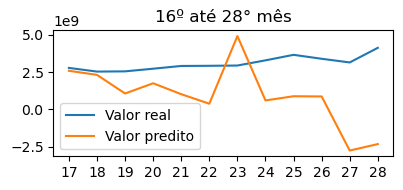

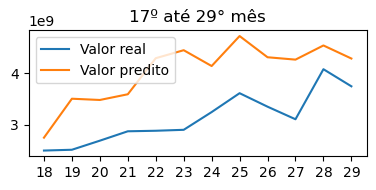

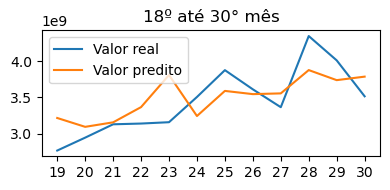

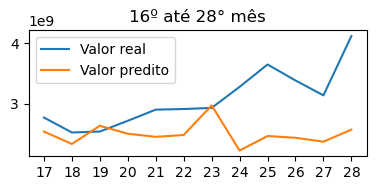

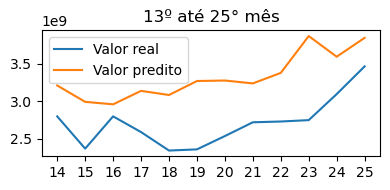

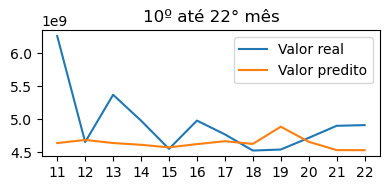

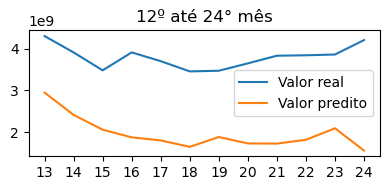

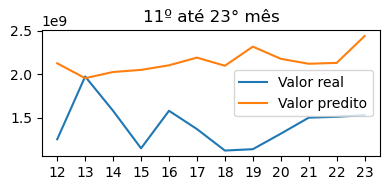

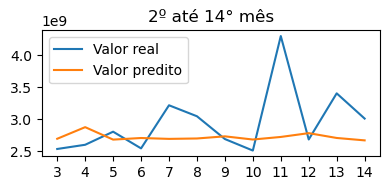

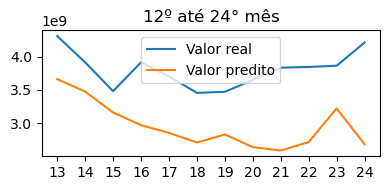

Best Bidirectional LSTM, trained for 500 epochs with early stopping
	MAPE: 11.005457186225172


In [45]:
early_stopping = EarlyStopping(monitor='loss', patience=40)

best_bi_model = None
best_bi_mape = float('inf')

for i in range(10):    
    model = bi_lstm(n_neurons=100, n_features=12, n_target=1)
    model.fit(X_train, y_train, epochs=500, verbose=0, batch_size=6, 
                callbacks=[early_stopping]) # (154, 12), (154,)

    rmse, mae, mape = get_val_metrics(model, X_val, y_val, False, True)

    if(mape < best_bi_mape):
        best_bi_mape = mape
        best_bi_model = model

print(f'Best Bidirectional LSTM, trained for {b_ep} epochs with early stopping')
print(f'\tMAPE: {best_bi_mape}')

# Multivariado

## Casos multivariados com ICMS e uma série exógena

#### Preparando as tabelas com os lags

In [46]:
#['ANO', 'MES', 'ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA']
icms_cb_raw = df[['ICMS', 'CB']].copy()
icms_petr_raw = df[['ICMS', 'PETROLEO']].copy() 
icms_trib_raw = df[['ICMS', 'TRIBUTOS']].copy()
icms_ener_raw = df[['ICMS', 'ENERGIA']].copy()

In [94]:
n_target = 2

icms_cb = series_to_supervised(icms_cb_raw, ['ICMS', 'CB'], 12, 1)
icms_petr = series_to_supervised(icms_petr_raw, ['ICMS', 'PETROLEO'], 12, 1)  
icms_trib = series_to_supervised(icms_trib_raw, ['ICMS', 'TRIBUTOS'], 12, 1)
icms_ener = series_to_supervised(icms_ener_raw, ['ICMS', 'ENERGIA'], 12, 1)

icms_cb = np.array(icms_cb)
icms_petr = np.array(icms_petr)
icms_trib = np.array(icms_trib)
icms_ener = np.array(icms_ener)

cb_cv_X, cb_cv_y = icms_cb[:, :-n_target], icms_cb[:, -n_target]
petr_cv_X, petr_cv_y = icms_petr[:, :-n_target], icms_petr[:, -n_target]
trib_cv_X, trib_cv_y = icms_trib[:, :-n_target], icms_trib[:, -n_target]
ener_cv_X, ener_cv_y = icms_ener[:, :-n_target], icms_ener[:, -n_target]

cb_X, cb_y = icms_cb[:, :-n_target], icms_cb[:, -n_target:]
petr_X, petr_y = icms_petr[:, :-n_target], icms_petr[:, -n_target:]
trib_X, trib_y = icms_trib[:, :-n_target], icms_trib[:, -n_target:]
ener_X, ener_y = icms_ener[:, :-n_target], icms_ener[:, -n_target:]

cb_X = cb_X.reshape((cb_X.shape[0], cb_X.shape[1], 1))
cb_y = cb_y.reshape((cb_y.shape[0], 2))

petr_X = petr_X.reshape((petr_X.shape[0], petr_X.shape[1], 1))
petr_y = petr_y.reshape((petr_y.shape[0], 2))

trib_X = trib_X.reshape((trib_X.shape[0], trib_X.shape[1], 1))
trib_y = trib_y.reshape((trib_y.shape[0], 2))

ener_X = ener_X.reshape((ener_X.shape[0], ener_X.shape[1], 1))
ener_y = ener_y.reshape((ener_y.shape[0], 2))

cb_X_train, cb_y_train = cb_X[:154, :], cb_y[:154, :]
cb_X_val, cb_y_val = cb_X[154:, :], cb_y[154:, :]

petr_X_train, petr_y_train = petr_X[:154, :], petr_y[:154, :]
petr_X_val, petr_y_val = petr_X[154:, :], petr_y[154:, :]

trib_X_train, trib_y_train = trib_X[:154, :], trib_y[:154, :]
trib_X_val, trib_y_val = trib_X[154:, :], trib_y[154:, :]

ener_X_train, ener_y_train = ener_X[:154, :], ener_y[:154, :]
ener_X_val, ener_y_val = ener_X[154:, :], ener_y[154:, :]

#### GridSearch CV

In [ ]:
n_target = 1
n_features = 24

# Use the random grid to search for best hyperparameters
# First create the base model to tune
bi_keras = KerasRegressor(build_fn=bi_lstm, n_neurons=100, n_features=n_features, 
                          n_target=n_target,verbose=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
icms_cb_random = RandomizedSearchCV(estimator = bi_keras, n_iter = 6, cv = 3, 
                                    param_distributions = random_grid, 
                                    scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_petr_random = RandomizedSearchCV(estimator = bi_keras, n_iter = 6, cv = 3, 
                                    param_distributions = random_grid, 
                                    scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_trib_random = RandomizedSearchCV(estimator = bi_keras, n_iter = 6, cv = 3, 
                                    param_distributions = random_grid, 
                                    scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_ener_random = RandomizedSearchCV(estimator = bi_keras, n_iter = 6, cv = 3, 
                                    param_distributions = random_grid, 
                                    scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)


# Fit the random search model
icms_cb_random.fit(cb_cv_X, cb_cv_y)
icms_petr_random.fit(petr_cv_X, petr_cv_y)
icms_trib_random.fit(trib_cv_X, trib_cv_y)
icms_ener_random.fit(ener_cv_X, ener_cv_y)

cb_ep, cb_bs = get_best_parameters(icms_cb_random.best_params_)
petr_ep, petr_bs = get_best_parameters(icms_petr_random.best_params_)
trib_ep, trib_bs = get_best_parameters(icms_trib_random.best_params_)
ener_ep, ener_bs = get_best_parameters(icms_ener_random.best_params_)

#### Divisão de treinamento e validação

#### Treinamento dos 4 modelos

Caso ICMS + Cesta Básica

Caso ICMS + Produção Total de Petróleo 

Caso ICMS + Total Receita Tributária RJ

Caso ICMS + Consumo de Energia Total Sudeste

#### Treinamento dos 4 modelos com parâmetros otimizados

In [164]:
n_target = 2

cb_tuple = get_best_model(cb_ep, cb_bs, 
                         cb_X_train, cb_y_train, 
                         cb_X_val, cb_y_val)
best_cb, best_config, rmse_cb, mae_cb, mape_cb = cb_tuple
cb_n_neurons, cb_activation = best_config.values()    

Best MAPE: 15.066


In [165]:
n_target = 2

petr_tuple = get_best_model(petr_ep, petr_bs,
                            petr_X_train, petr_y_train,
                            petr_X_val, petr_y_val)
best_petr, best_config, rmse_petr, mae_petr, mape_petr = petr_tuple
petr_n_neurons, petr_activation = best_config.values()

Best MAPE: 16.025


In [166]:
n_target = 2

trib_tuple = get_best_model(trib_ep, trib_bs,
                            trib_X_train, trib_y_train,
                            trib_X_val, trib_y_val)
best_trib, best_config, rmse_trib, mae_trib, mape_trib = trib_tuple
trib_n_neurons, trib_activation = best_config.values()

Best MAPE: 14.670


In [167]:
n_target = 2

ener_tuple = get_best_model(ener_ep, ener_bs,
                            ener_X_train, ener_y_train,
                            ener_X_val, ener_y_val)
best_ener, best_config, rmse_ener, mae_ener, mape_ener = ener_tuple
ener_n_neurons, ener_activation = best_config.values()

Best MAPE: 16.382


#### Cálculo das métricas de erro no conjunto de validação

In [168]:
n_target = 2

early_stopping = EarlyStopping(monitor='loss', patience=40)

cb_model = None
petr_model = None
trib_model = None
ener_model = None
best_cb_mape = float('inf')
best_petr_mape = float('inf')
best_trib_mape = float('inf')
best_ener_mape = float('inf')

for i in range(10):
    cb = bi_lstm(n_neurons=cb_n_neurons, n_features=24, n_target=2, activation=cb_activation)
    petr = bi_lstm(n_neurons=petr_n_neurons, n_features=24, n_target=2, activation=petr_activation)
    trib = bi_lstm(n_neurons=trib_n_neurons, n_features=24, n_target=2, activation=trib_activation)
    ener = bi_lstm(n_neurons=ener_n_neurons, n_features=24, n_target=2, activation=ener_activation)

    cb.fit(cb_X_train, cb_y_train, epochs=cb_ep, batch_size=cb_bs, verbose=0, callbacks=[early_stopping])
    petr.fit(petr_X_train, petr_y_train, epochs=petr_ep, batch_size=petr_bs, verbose=0, callbacks=[early_stopping])
    trib.fit(trib_X_train, trib_y_train, epochs=trib_ep, batch_size=trib_bs, verbose=0, callbacks=[early_stopping])
    ener.fit(ener_X_train, ener_y_train, epochs=ener_ep, batch_size=ener_bs, verbose=0, callbacks=[early_stopping])

    cb_rmse, cb_mae, cb_mape = get_val_metrics(cb, cb_X_val, cb_y_val, False, False)
    petr_rmse, petr_mae, petr_mape = get_val_metrics(petr, petr_X_val, petr_y_val, False, False)
    trib_rmse, trib_mae, trib_mape = get_val_metrics(trib, trib_X_val, trib_y_val, False, False)
    ener_rmse, ener_mae, ener_mape = get_val_metrics(ener, ener_X_val, ener_y_val, False, False)

    if cb_mape < best_cb_mape:
        best_cb_mape = cb_mape
        cb_model = cb
    if petr_mape < best_petr_mape:
        best_petr_mape = petr_mape
        petr_model = petr
    if trib_mape < best_trib_mape:
        best_trib_mape = trib_mape
        trib_model = trib
    if ener_mape < best_ener_mape:
        best_ener_mape = ener_mape
        ener_model = ener



In [ ]:
cb_test_model = bi_lstm(n_neurons=100, n_features=24, n_target=2, activation='relu')
cb_test_model.fit(cb_X_train, cb_y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])

cb_rmse, cb_mae, cb_mape = get_val_metrics(cb_test_model, cb_X_test, cb_y_test, False, False)

In [169]:
print_best("CB + ICMS", cb_ep, cb_n_neurons, cb_activation, cb_mape)
print_best("PETR + ICMS", petr_ep, petr_n_neurons, petr_activation, petr_mape)
print_best("TRIB + ICMS", trib_ep, trib_n_neurons, trib_activation, trib_mape)
print_best("ENER + ICMS", ener_ep, ener_n_neurons, ener_activation, ener_mape)


Best LSTM Bidirectional model: CB + ICMS
	Epochs: 800 | Neurons: 100 | Activation: relu
	MAPE: 18.52
Best LSTM Bidirectional model: PETR + ICMS
	Epochs: 500 | Neurons: 150 | Activation: tanh
	MAPE: 15.41
Best LSTM Bidirectional model: TRIB + ICMS
	Epochs: 500 | Neurons: 200 | Activation: tanh
	MAPE: 16.26
Best LSTM Bidirectional model: ENER + ICMS
	Epochs: 500 | Neurons: 50 | Activation: relu
	MAPE: 25.07


## Multivariado com todas as séries

#### Criação da tabela contendo todas as séries

In [171]:
all_series_raw = df[['ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA']]
all_df = series_to_supervised(all_series_raw, ['ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA'], 12, 1)


#### Divisão em treino e validação

In [183]:
all_df = np.array(all_df)

all_cv_X, all_cv_y = all_df[:, :-5], all_df[:, -5]

all_X, all_y = all_df[:, :-5], all_df[:, -5:]

all_X = all_X.reshape((all_X.shape[0], all_X.shape[1], 1))
all_y = all_y.reshape((all_y.shape[0], 5))

all_X_train, all_y_train = all_X[:154, :], all_y[:154, :]
all_X_val, all_y_val = all_X[154:, :], all_y[154:, :]

#### Treinamento e cálculo das métricas de erro no conjunto de validação

In [173]:
n_target = 5
n_features = 60

all_model = KerasRegressor(build_fn=bi_lstm, n_neurons=60, n_features=60, 
                           n_target=n_target, verbose=0)

all_random = RandomizedSearchCV(estimator = all_model, n_iter = 6, cv = 3, 
                                param_distributions = random_grid, 
                                scoring='neg_mean_squared_error',
                                verbose=2, n_jobs = -1)

all_random.fit(all_cv_X, all_cv_y)

all_ep, all_bs = all_random.best_params_.values()
                                

C:\Users\jpkqv\AppData\Local\Temp\ipykernel_2792\724811953.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  all_model = KerasRegressor(build_fn=bi_lstm, n_neurons=60, n_features=60,


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\jpkqv\anaconda3\envs\icms\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
# Finding best Bidirectional model with the best parameters
neurons = [100, 150, 200]
fn_activation = ['relu', 'tanh']

n_features = 60
n_targets = 5

best_all_model = None
best_all_mape = float('inf')
best_all_config = None

low_patience_es = EarlyStopping(monitor='loss', patience=25)
for n_neurons in neurons:
    for activation in fn_activation:

        model = bi_lstm(n_neurons=n_neurons, n_features=n_features, n_target=n_target, activation=activation)
        model.fit(X_train, y_train, epochs=all_ep, batch_size=all_bs, verbose=0, callbacks=[low_patience_es])

        rmse, mae, mape = get_val_metrics(model, X_val, y_val, False, False)

        if mape < best_mape:
            best_all_mape = mape
            best_all_model = model
            best_all_config = {'n_neurons': n_neurons, 'activation': activation}
            

n_neurons = best_all_config['n_neurons']
activation = best_all_config['activation']

print(f'Best Bidirectional LSTM multivariate all series:')    
print(f'\tNeurons: {n_neurons}, Activation: {activation}')
print(f'\tEpochs: {b_ep}, Batch size: {b_bs}')
print(f'\tMAPE: {best_mape}')

In [196]:

best_all_model = bi_lstm(n_neurons=200, n_features=60, n_target=5, activation='relu')
model.fit(all_X_train, all_y_train, epochs=500, batch_size=16, verbose=1, callbacks=[early_stopping])

all_rmse, all_mae, all_mape = get_val_metrics(best_all_model, all_X_val, all_y_val, False, False)

print(f'Best Bidirectional LSTM multivariate all series:')
print(f'\tNeurons: 200, Activation: relu')
print(f'\tEpochs: 500, Batch size: 16')
print(f'\tMAPE: {all_mape}')

Epoch 1/500
10/10 [==============================] - 3s 265ms/step - loss: 0.0168
Epoch 2/500
10/10 [==============================] - 3s 267ms/step - loss: 0.0168
Epoch 3/500
10/10 [==============================] - 3s 270ms/step - loss: 0.0167
Epoch 4/500
10/10 [==============================] - 3s 264ms/step - loss: 0.0167
Epoch 5/500
10/10 [==============================] - 3s 270ms/step - loss: 0.0167
Epoch 6/500
10/10 [==============================] - 3s 269ms/step - loss: 0.0167
Epoch 7/500
10/10 [==============================] - 3s 279ms/step - loss: 0.0167
Epoch 8/500
10/10 [==============================] - 3s 266ms/step - loss: 0.0167
Epoch 9/500
10/10 [==============================] - 3s 273ms/step - loss: 0.0168
Epoch 10/500
10/10 [==============================] - 3s 261ms/step - loss: 0.0168
Epoch 11/500
10/10 [==============================] - 3s 270ms/step - loss: 0.0167
Epoch 12/500
10/10 [==============================] - 3s 281ms/step - loss: 0.0167
Epoch 13/500


### Comparação de todos os resultados no conjunto de validação

In [ ]:
#Comparando os resultados
print_mean_error("Validação: Parâmetros Default Univariado",
                 default_rmse, default_mae, default_mape)
print_mean_error("Validação: Parâmetros Otimizados Univariado",
                best_rmse, best_mae, best_mape)
print_mean_error("Validação: CB + ICMS Multivariado",
                cb_rmse, cb_mae, cb_mape)
print_mean_error("Validação: CB + ICMS Otimizado Multivariado",
                 opt_cb_rmse, opt_cb_mae, opt_cb_mape)
print_mean_error("Validação: Petróleo + ICMS Multivariado",
                petr_rmse, petr_mae, petr_mape)
print_mean_error("Validação: Petróleo + ICMS Otimizado Multivariado",
                    opt_petr_rmse, opt_petr_mae, opt_petr_mape) 
print_mean_error("Validação: Tributos + ICMS Multivariado",
                trib_rmse, trib_mae, trib_mape)
print_mean_error("Validação: Tributos + ICMS Otimizado Multivariado",
                opt_trib_rmse, opt_trib_mae, opt_trib_mape)
print_mean_error("Validação: Energia + ICMS Multivariado",
                ener_rmse, ener_mae, ener_mape)
print_mean_error("Validação: Energia + ICMS Otimizado Multivariado",
                opt_ener_rmse, opt_ener_mae, opt_ener_mape)
print_mean_error("Validação: Todos os parâmetros Multivariado",
                all_rmse, all_mae, all_mape)      

# Resultados de Teste

## Teste Univariado

In [219]:
test = icms[-1:].values[0][1:].reshape((1, 12, 1))
print(test.shape)

(1, 12, 1)


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


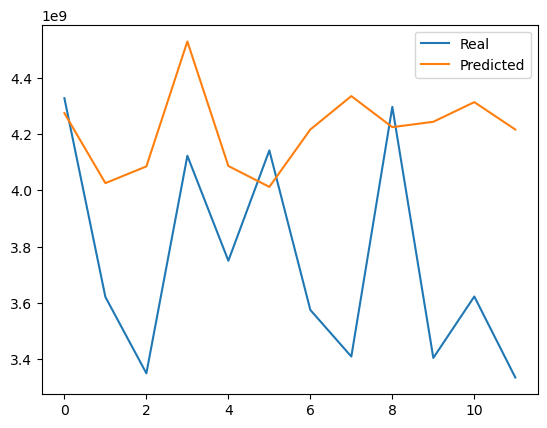

In [227]:
# Using test set Univariate

#Getting 12 months before the test set
test = icms[-1:].values[0][1:]
pred = []

for i in range(12):
    y_hat = best_bi_model.predict(test.reshape(1, 12, 1))
    test = np.concatenate([test[1:], y_hat.reshape(1)], axis=0)
    #Desnormalizing
    y_hat = y_hat * (_max - _min) + _min
    pred.append(y_hat[0])

#Retrending
for i in range(12):
    if i == 0:
        pred[i] = pred[i] + initial_icms_test_value
    else:
        pred[i] = pred[i] + pred[i-1]

pred = np.array(pred)

rmse, mae, mape = calculate_error(pred, icms_test_real)

plt.plot(icms_test_real, label='Real')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()


In [228]:
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test MAPE: {mape:.2f}')

Test RMSE: 594239545.29
Test MAE: 516060208.09
Test MAPE: 14.62


## Teste Multivariado (ICMS + 1 série Exógena)

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 25ms/step


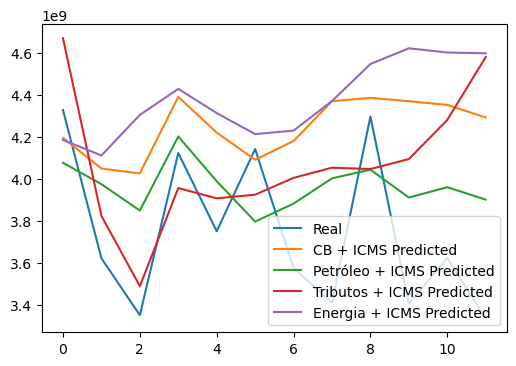

In [231]:
#Multivariado
icms_cb = series_to_supervised(icms_cb_raw, ['ICMS', 'CB'], 12, 1)
icms_petr = series_to_supervised(icms_petr_raw, ['ICMS', 'PETROLEO'], 12, 1)  
icms_trib = series_to_supervised(icms_trib_raw, ['ICMS', 'TRIBUTOS'], 12, 1)
icms_ener = series_to_supervised(icms_ener_raw, ['ICMS', 'ENERGIA'], 12, 1)

cb_test = icms_cb[-1:].values[0][2:]
petr_test = icms_petr[-1:].values[0][2:]
trib_test = icms_trib[-1:].values[0][2:]
ener_test = icms_ener[-1:].values[0][2:]

cb_pred = get_prediction(cb_test, cb_model, initial_icms_test_value)
petr_pred = get_prediction(petr_test, petr_model, initial_icms_test_value)
trib_pred = get_prediction(trib_test, trib_model, initial_icms_test_value)
ener_pred = get_prediction(ener_test, ener_model, initial_icms_test_value)


plt.figure(figsize=(6,4))
plt.plot(icms_test_real, label='Real')
plt.plot(cb_pred, label='CB + ICMS Predicted')
plt.plot(petr_pred, label='Petróleo + ICMS Predicted')
plt.plot(trib_pred, label='Tributos + ICMS Predicted')
plt.plot(ener_pred, label='Energia + ICMS Predicted')
plt.legend()
plt.show()

In [ ]:
all_df = series_to_supervised(all_series_raw, ['ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA'], 12, 1)
all_test = all_df[-1:].values[0][5:]

all_pred = []

for i in range(12):
    y_hat = all_model.predict(all_test.reshape(1, 60, 1))
    all_test = np.concatenate([all_test[5:], y_hat.reshape(-1)], axis=0)
    #Desnormalizing
    y_hat = y_hat * (_max - _min) + _min
    all_pred.append(y_hat[0][0])

#Retrending
for i in range(12):
    if i == 0:
        all_pred[i] = all_pred[i] + initial_icms_test_value
    else:
        all_pred[i] = all_pred[i] + all_pred[i-1]

all_pred = np.array(all_pred)

plt.figure(figsize=(6,4))
plt.plot(icms_test_real, label='Real')
plt.plot(all_pred, label='Todos as Séries Predicted')
plt.legend()
plt.show()

In [233]:
print_results('Testes: ICMS Univariado', pred, icms_test_real)
print_results('Testes: CB + ICMS Multivariado ', cb_pred, icms_test_real)
print_results('Testes: Petróleo + ICMS Multivariado ', petr_pred, icms_test_real)
print_results('Testes: Tributos + ICMS Multivariado ', trib_pred, icms_test_real)  
print_results('Testes: Energia + ICMS Multivariado ', ener_pred, icms_test_real)
#print_results('Testes: Todos os parâmetros Multivariado ', all_pred, icms_test_real)

Testes: ICMS Univariado
	RMSE: 594239545.29
	MAE: 516060208.09
	MAPE: 14.62
----------------------------------------
Testes: CB + ICMS Multivariado 
	RMSE: 621421812.43
	MAE: 527901030.95
	MAPE: 14.98
----------------------------------------
Testes: Petróleo + ICMS Multivariado 
	RMSE: 389496210.21
	MAE: 360834838.99
	MAPE: 10.01
----------------------------------------
Testes: Tributos + ICMS Multivariado 
	RMSE: 532302009.71
	MAE: 428526582.90
	MAPE: 11.97
----------------------------------------
Testes: Energia + ICMS Multivariado 
	RMSE: 766277651.77
	MAE: 654714273.40
	MAPE: 18.55
----------------------------------------
Testes: Todos os parâmetros Multivariado 
	RMSE: 10471952825.92
	MAE: 9216872418.26
	MAPE: 252.20
----------------------------------------
